## Part 2:

In [21]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import datetime
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


seed = 309
random.seed(seed)
np.random.seed(seed)




adult = pd.read_csv("/Users/keirynhart/Documents/Uni/Comp 309/Assignment 4/adult.csv")
adult_test = pd.read_csv("/Users/keirynhart/Documents/Uni/Comp 309/Assignment 4/adult_test.csv")

In [22]:
adult.head()

,Age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data preparation

In [23]:
adult.isnull().values.any()

adult_test.isnull().values.any()

adult_test['native_country'].unique()



array([' United-States', ' ?', ' Peru', ' Guatemala', ' Mexico',
       ' Dominican-Republic', ' Ireland', ' Germany', ' Philippines',
       ' Thailand', ' Haiti', ' El-Salvador', ' Puerto-Rico', ' Vietnam',
       ' South', ' Columbia', ' Japan', ' India', ' Cambodia', ' Poland',
       ' Laos', ' England', ' Cuba', ' Taiwan', ' Italy', ' Canada',
       ' Portugal', ' China', ' Nicaragua', ' Honduras', ' Iran',
       ' Scotland', ' Jamaica', ' Ecuador', ' Yugoslavia', ' Hungary',
       ' Hong', ' Greece', ' Trinadad&Tobago',
       ' Outlying-US(Guam-USVI-etc)', ' France'], dtype=object)

In [24]:
#dropping fnlwgt

adult = adult.drop(['fnlwgt'], axis=1)
adult_test = adult_test.drop(['fnlwgt'], axis=1)

Notes:
- capital gains and losses have alot of occurances of 0 => possible as many people may not have investments etc.
- Salary variable is imbalanced
- hours per week has values of 99 (seems kind of unlikely but again possible)
- fnlwgt not very clear so dropping.
- '?' values in occupation and work_class => going to change to other.
- the training and testing sets have slightly different values for income e.g. training set has " <=50K" and test set has " <=50K." with the full stop, this could cause problems so im going to make them the same.

# replacing values

In [25]:
adult['native_country'] = adult['native_country'].replace(' Holand-Netherlands', 'other')

adult_test = adult_test.replace(' <=50K.', ' <=50K')
adult_test = adult_test.replace(' >50K.', ' >50K')

adult = adult.replace(' ?', 'other')
adult_test = adult_test.replace(' ?', 'other')

adult = adult.replace(' >50K', 1)
adult = adult.replace(' <=50K', 0)

adult_test = adult_test.replace(' >50K', 1)
adult_test = adult_test.replace(' <=50K', 0)

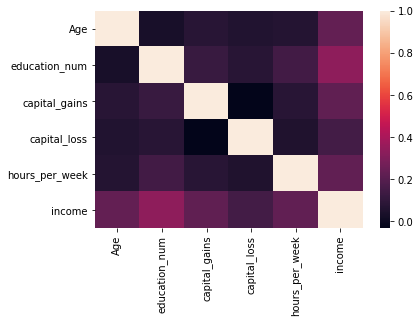

In [26]:
sns.heatmap(adult.corr())

## Data Preparation:

In [29]:
cat_vars = ['work_class', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list=pd.get_dummies(adult[var], prefix = var)
    data1=adult.join(cat_list)
    adult = data1 

In [30]:
cat_vars = ['work_class', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
    
for var in cat_vars:
    cat_list1='var'+'_'+var
    cat_list1=pd.get_dummies(adult_test[var], prefix = var)
    data2=adult_test.join(cat_list1)
    adult_test = data2

In [31]:
cat_vars = ['work_class', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
data_vars = adult.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

adult = adult[to_keep]


cat_vars = ['work_class', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
data_vars2 = adult_test.columns.values.tolist()
to_keep = [i for i in data_vars2 if i not in cat_vars]

adult_test = adult_test[to_keep]

In [37]:
adult.shape

(32561, 107)

In [38]:
adult_train_labels = adult['income']

adult_train_full = adult.copy()

adult_train = adult.drop(['income'], axis = 1)

adult_test_labels = adult_test["income"]

adult_test_full = adult_test.copy()

adult_test = adult_test.drop(['income'], axis = 1)

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(adult_train_full)
adult_train = scaler.transform(adult_train_full)
adult_test = scaler.transform(adult_test_full)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 20)
adult_train_pca = pca.fit(adult_train).transform(adult_train)
#adult_test_pca = pca.fit(adult_test).transform(adult_test)
adult_test_pca = pca.transform(adult_test)

adult_train_pca

array([[-0.58821561, -2.17634371, -0.85285358, ...,  0.8623681 ,
        -1.59536647,  0.629659  ],
       [ 2.62497537, -0.9079246 , -0.28638711, ..., -0.71032386,
         0.1249056 ,  0.41412738],
       [-0.90525994,  0.9813072 , -1.23146921, ..., -0.60124541,
         0.71508377,  0.13065016],
       ...,
       [-2.31676268, -0.89385284,  0.16395306, ...,  1.23573337,
         0.18859842, -0.34846767],
       [-2.03634137,  1.12583967, -1.7130109 , ..., -0.14133667,
        -0.31676917, -0.39740145],
       [ 1.36599419, -1.98912898,  0.45075261, ...,  0.45341797,
        -0.16893522,  0.42016202]])

In [ ]:
print('kNN')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(adult_train_pca, adult_train_labels)

neigh_pred = cross_val_predict(neigh, adult_train_pca, adult_train_labels, cv = 10)

neigh_accuracy = accuracy_score(neigh_pred, adult_train_labels)
neigh_precision = precision_score(adult_train_labels, neigh_pred)
neigh_recall = recall_score(adult_train_labels, neigh_pred)
neigh_f1 = f1_score(adult_train_labels, neigh_pred)

print(neigh_accuracy, neigh_precision, neigh_recall, neigh_f1)

y_pred = neigh.predict(adult_test_pca)
y_pred



neigh.score(adult_test_pca, adult_test_labels)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(adult_test_labels, y_pred)
matrix

from sklearn.metrics import precision_score, recall_score


print(classification_report(adult_test_labels, y_pred))

print('Naive Bayes')



from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
NB = GaussianNB()


NB.fit(adult_train_pca, adult_train_labels)
NB_pred = cross_val_predict(NB, adult_train_pca, adult_train_labels, cv = 10)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

NB_accuracy = accuracy_score(NB_pred, adult_train_labels)
NB_precision = precision_score(adult_train_labels, NB_pred)
NB_recall = recall_score(adult_train_labels, NB_pred)
NB_f1 = f1_score(adult_train_labels, NB_pred)

print(NB_accuracy, NB_precision, NB_recall, NB_f1)



y_pred1 = NB.predict(adult_test_pca)

matrix1 = confusion_matrix(adult_test_labels, y_pred1)
matrix1



NB.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred1))

print('SVM')

from sklearn import svm
svm = svm.SVC()
svm.fit(adult_train_pca, adult_train_labels)
svm_pred = cross_val_predict(svm, adult_train_pca, adult_train_labels, cv = 10)

svm_accuracy = accuracy_score(svm_pred, adult_train_labels)
svm_precision = precision_score(adult_train_labels, svm_pred)
svm_recall = recall_score(adult_train_labels, svm_pred)
svm_f1 = f1_score(adult_train_labels, svm_pred)

print(svm_accuracy, svm_precision, svm_recall, svm_f1)

y_pred2 = svm.predict(adult_test_pca)

matrix2 = confusion_matrix(adult_test_labels, y_pred2)
matrix2

svm.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred2))

print('Decision Tree')

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 1)
tree.fit(adult_train_pca, adult_train_labels)
tree_pred = cross_val_predict(tree, adult_train_pca, adult_train_labels, cv= 10)

tree_accuracy = accuracy_score(tree_pred, adult_train_labels)
tree_precision = precision_score(adult_train_labels, tree_pred)
tree_recall = recall_score(adult_train_labels, tree_pred)
tree_f1 = f1_score(adult_train_labels, tree_pred)

print(tree_accuracy, tree_precision, tree_recall, tree_f1)

y_pred3 = tree.predict(adult_test_pca)

matrix3 = confusion_matrix(adult_test_labels, y_pred3)
matrix3

tree.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred3))

print('Random Forest')

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

forest_pred = cross_val_predict(forest, adult_train_pca, adult_train_labels, cv= 10)

forest.fit(adult_train_pca, adult_train_labels)

forest_accuracy = accuracy_score(forest_pred, adult_train_labels)
forest_precision = precision_score(adult_train_labels, forest_pred)
forest_recall = recall_score(adult_train_labels, forest_pred)
forest_f1 = f1_score(adult_train_labels, forest_pred)

print(forest_accuracy, forest_precision, forest_recall, forest_f1)

y_pred4 = forest.predict(adult_test_pca)

matrix4 = confusion_matrix(adult_test_labels, y_pred4)
matrix4

forest.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred4))

print('Ada Boost')

from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada = ada.fit(adult_train_pca, adult_train_labels)
ada_pred = cross_val_predict(ada, adult_train_pca, adult_train_labels, cv=10)

ada_accuracy = accuracy_score(ada_pred, adult_train_labels)
ada_precision = precision_score(adult_train_labels, ada_pred)
ada_recall = recall_score(adult_train_labels, ada_pred)
ada_f1 = f1_score(adult_train_labels, ada_pred)

print(ada_accuracy, ada_precision, ada_recall, ada_f1)

y_pred5 = ada.predict(adult_test_pca)

matrix5 = confusion_matrix(adult_test_labels, y_pred5)
matrix5

ada.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred5))

print('Gradient Boosting')

from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier()

grad.fit(adult_train_pca, adult_train_labels)
grad_pred = cross_val_predict(grad, adult_train_pca, adult_train_labels, cv=10)

grad_accuracy = accuracy_score(grad_pred, adult_train_labels)
grad_precision = precision_score(adult_train_labels, grad_pred)
grad_recall = recall_score(adult_train_labels, grad_pred)
grad_f1 = f1_score(adult_train_labels, grad_pred)

print(grad_accuracy, grad_precision, grad_recall, grad_f1)

y_pred6 = grad.predict(adult_test_pca)

matrix6 = confusion_matrix(adult_test_labels, y_pred6)
matrix6

grad.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred6))

print('Linear Discriminant')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LD = LinearDiscriminantAnalysis()

LD.fit(adult_train_pca, adult_train_labels)
LD_pred = cross_val_predict(LD, adult_train_pca, adult_train_labels, cv = 10)

LD_accuracy = accuracy_score(LD_pred, adult_train_labels)
LD_precision = precision_score(adult_train_labels, LD_pred)
LD_recall = recall_score(adult_train_labels, LD_pred)
LD_f1 = f1_score(adult_train_labels, LD_pred)

print(LD_accuracy, LD_precision, LD_recall, LD_f1)

y_pred7 = LD.predict(adult_test_pca)

matrix7 = confusion_matrix(adult_test_labels, y_pred7)
matrix7

LD.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred7))

print('MLP Classifier')

from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier()

MLP.fit(adult_train_pca, adult_train_labels)
MLP_pred = cross_val_predict(MLP, adult_train_pca, adult_train_labels, cv = 10)

MLP_accuracy = accuracy_score(MLP_pred, adult_train_labels)
MLP_precision = precision_score(adult_train_labels, MLP_pred)
MLP_recall = recall_score(adult_train_labels, MLP_pred)
MLP_f1 = f1_score(adult_train_labels, MLP_pred)

print(MLP_accuracy, MLP_precision, MLP_recall, MLP_f1)

y_pred8 = MLP.predict(adult_test_pca)

matrix8 = confusion_matrix(adult_test_labels, y_pred8)
matrix8

MLP.score(adult_test_pca, adult_test_labels)

print(classification_report(adult_test_labels, y_pred8))

print('Logistic Regression')

from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

log.fit(adult_train_pca, adult_train_labels)
log_pred = cross_val_predict(log, adult_train_pca, adult_train_labels, cv = 10)

log_accuracy = accuracy_score(log_pred, adult_train_labels)
log_precision = precision_score(adult_train_labels, log_pred)
log_recall = recall_score(adult_train_labels, log_pred)
log_f1 = f1_score(adult_train_labels, log_pred)

print(log_accuracy, log_precision, log_recall, log_f1)

y_pred9 = log.predict(adult_test_pca)

log.score(adult_test_pca, adult_test_labels)



matrix9 = confusion_matrix(adult_test_labels, y_pred9)
matrix9

print(classification_report(adult_test_labels, y_pred9))

0.9447191425324775 0.9182938651156349 0.8456829486034945 0.8804939583056699
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     12435
           1       0.92      0.85      0.88      3846

    accuracy                           0.95     16281
   macro avg       0.94      0.91      0.92     16281
weighted avg       0.95      0.95      0.95     16281

0.8635484168176653 0.6956922368117945 0.7703099094503252 0.7311021001028868
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     12435
           1       0.70      0.78      0.74      3846

    accuracy                           0.87     16281
   macro avg       0.81      0.84      0.83     16281
weighted avg       0.88      0.87      0.87     16281

0.9738951506403366 0.9702677250100902 0.9197806402244612 0.9443498756056045
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12435
         

In [ ]:
table = {'Name':  ['kNN', 'naive Bayes', 'SVM', 'decision tree', 'random forest',  'AdaBoost', 'gradient Boosting', 'linear discriminant analysis', 'multi-layer perceptron', 'logistic regression'],
         'Accuracy': [0.94,0.86,0.98,0.87,0.97,0.92,0.95,0.89,0.99,0.90],
         'Precision': [0.93,0.81,0.98,0.82,0.97,0.89,0.94,0.86,0.99,0.87],
         'Recall': [0.91,0.84,0.96,0.80,0.94,0.88,0.92,0.83,0.99,0.96],
         'F1':[0.92,0.82,0.97,0.81,0.95,0.89,0.93,0.85,0.99,0.86]}
         
         

        
table = pd.DataFrame (table, columns = ['Name','Accuracy','Precision', 'Recall', 'F1'])



table